# Experiment & Test - SmolDocling For OCR Tasks

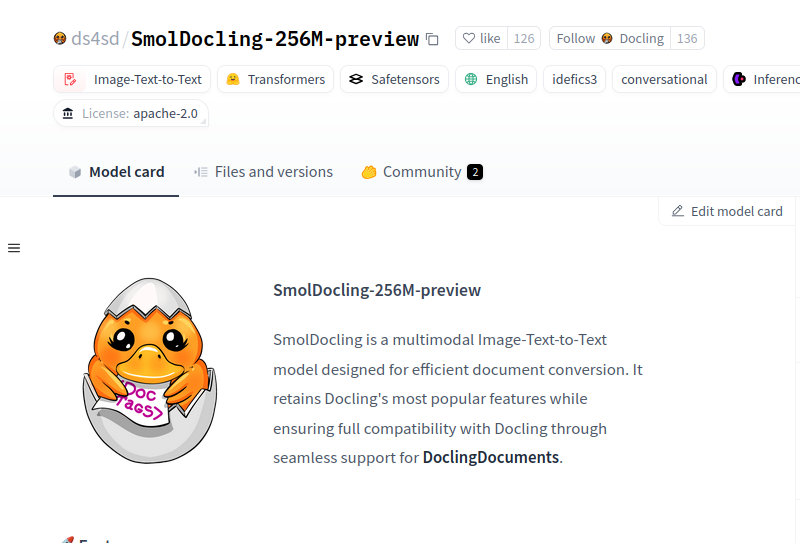

In [ ]:
# pip install torch
# pip install transformers
!pip install docling_core

In [3]:
import torch
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
image = load_image("https://upload.wikimedia.org/wikipedia/commons/7/76/GazettedeFrance.jpg")

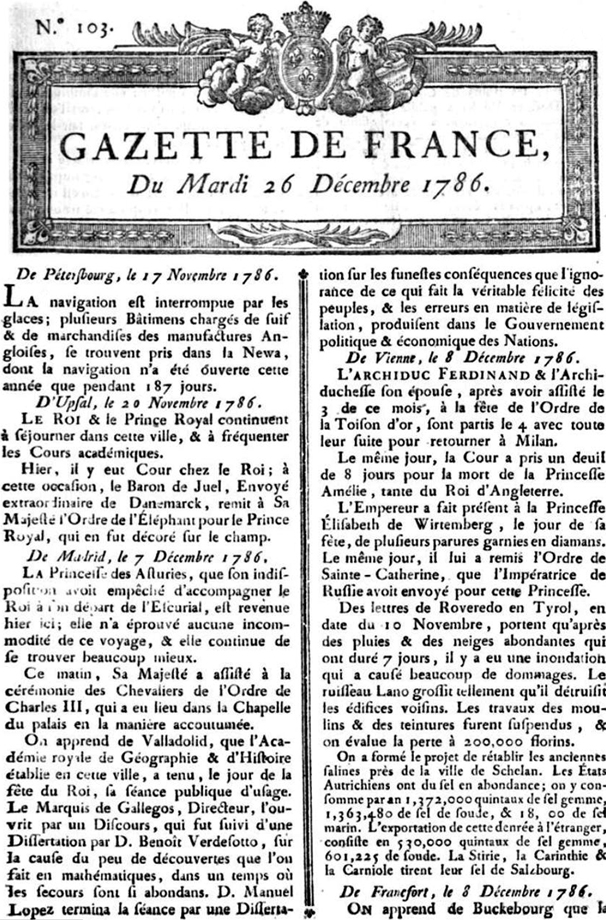

In [8]:
image

In [11]:
processor = AutoProcessor.from_pretrained("ds4sd/SmolDocling-256M-preview")
model = AutoModelForVision2Seq.from_pretrained(
    "ds4sd/SmolDocling-256M-preview",
    torch_dtype=torch.bfloat16,
    # _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager",
).to(DEVICE)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [12]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=7

In [24]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

In [27]:
prompt = processor.apply_chat_template(messages, tokenize=False)

In [37]:
inputs = processor(text=prompt, images=[image], return_tensors="pt")

In [38]:
inputs = inputs.to(DEVICE)

In [39]:
generated_ids = model.generate(**inputs, max_new_tokens=8192)
prompt_length = inputs.input_ids.shape[1]
trimmed_generated_ids = generated_ids[:, prompt_length:]

In [40]:
doctags = processor.batch_decode(
    trimmed_generated_ids,
    skip_special_tokens=False,
)[0].lstrip()

In [49]:
doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)

Assistant: <doctag><picture><loc_19><loc_3><loc_491><loc_66><logo></picture>
<section_header_level_1><loc_49><loc_67><loc_453><loc_109>GAZETTE DE FRANCE, Du Mardi 26 Decembre 1786.</section_header_level_1>
<picture><loc_10><loc_121><loc_491><loc_138><logo></picture>
<text><loc_10><loc_145><loc_230><loc_155>De Pitefourg, le 17 Novembre 1786.</text>
<text><loc_10><loc_159><loc_230><loc_216>LA navigation eft interrompue par les glaces; pluieurs Baimtens chargés de fuif & de marchandifes des manufacures An- glofies, fe trouvent pris dans la Newa dont la navigation n'ete ouverte cette année que pendant 187 jours.</text>
<text><loc_10><loc_215><loc_210><loc_225>D'Upfal, le 20 Novembre 1786.</text>
<text><loc_10><loc_224><loc_230><loc_252>LE ROI & le Prince Royal continuent a fejourner dans cette ville, & a fréquenter les Cours académiques.</text>
<text><loc_10><loc_251><loc_230><loc_297>Hier, il y eut Cour chez le Roi; a cette occasion, le Baron de Juel, Envoyé extraoirinaire de Danemarche, 

In [54]:
doc = DoclingDocument(name="Document")
doc = doc.load_from_doctags(doctags_doc)

In [55]:
print(doc.export_to_markdown())

<!-- image -->

## GAZETTE DE FRANCE, Du Mardi 26 Decembre 1786.

<!-- image -->

De Pitefourg, le 17 Novembre 1786.

LA navigation eft interrompue par les glaces; pluieurs Baimtens chargés de fuif &amp; de marchandifes des manufacures An- glofies, fe trouvent pris dans la Newa dont la navigation n'ete ouverte cette année que pendant 187 jours.

D'Upfal, le 20 Novembre 1786.

LE ROI &amp; le Prince Royal continuent a fejourner dans cette ville, &amp; a fréquenter les Cours académiques.

Hier, il y eut Cour chez le Roi; a cette occasion, le Baron de Juel, Envoyé extraoirinaire de Danemarche, remit à Sa Majelle I'Ordre de I'Elephant pour le Prince Royal, qui en fut décoreur le champ.

De Mridi, le 7 Decembre 1786. La Princeif des Afluries, que on infid-

poufit avoir empeclède d'accompagner le Roi à i n de l'Euricial, elt revenu hier ici; elle n'e prouvé au cune incom- modité de ce voyage, &amp; elle continue de f et trouver beaucoup mieux.

Ce matin, Sa Majelle a affié la ceremonie des 

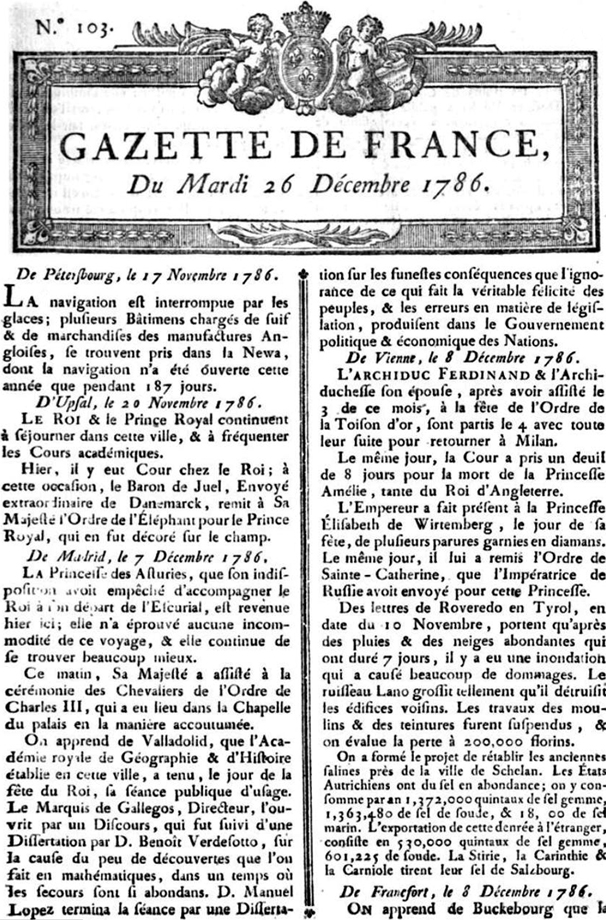

In [53]:
image